## Crypto Currency and Portfolio Construction

- Ryan Milgrim and Roo Fernando
- University of Washington
- CFRM 521: Machine Learning
- June, 3, 2024

### 1. Project Design

#### Problem Statement

Cryptocurrency markets, first introduced in 2009, have seen widespread adoption despite their speculative nature. Traditional investment strategies are typically formulated through expectations of cashflows, interest rates, and uncertainty. When applying similar practices to cryptocurrencies markets, the only element which remains is the uncertainty due to the extreme price volatility. As a result, many portfolio managers have a reluctance to adopt the asset class, often referencing <a href="https://en.wikipedia.org/wiki/Tulip_mania">Tulip Mania</a> when justifying their reason for the dismissal of any crypto coin's relevancy in a portfolio.


#### Project Goal

In this project, we aim to develop cryptocurrency strategies and portfolios with machine learning. We hope that these methods will provide investors with tools which they could use to better navigate cryptocurrency markets in the absence of economic fundamentals. Our models will try to determine which coins are the most likely to yield the best or highest return on the following day.

Initially we aimed for this our project to produce portfolios which had optimal or superior Sharpe Ratios portfolio. We have deviated from this slightly, instead focusing on models which simply predict tomorrow’s best coin. This change reduced the complexity our of project dramatically, and allowed us to focus more on machine learning for the timeseries prediction of t+1 rather than optimization topics with CVXPY which was not a part of this course.

To figure out if our models are adding value, we will compare the out of sample performance against LTC's performance. LTC is the best returning coin in the last 40% of our data which we will use for testing thought this analysis. If our model is able to beat the return of the best coin (within the test set), then this would indicate that our models have insight into market timing and would be useful to an investor seeking to maximize their return.

While we do believe that investors are focused on the best risk adjusted return, despite our project’s emphasis on maximizing return in isolation. This will be a topic of future research which I will discuss towards the end. However, we have learned that this approach involves a significant amount of object-oriented programing to create an “end to end” machine learning approach to portfolio management. 

Our project will make use of open, high, low, close data along with derived features often referred to as technical indicators. To evaluate the success or failure of our models, we will employ a back testing function to see the portfolio's performance and volatility over time against the benchmark. Ideally, we see an improvement in either the return of the portfolio or a reduction in volatility.

### 2. Data Processing and Feature Engineering

#### Data Source

The data we will be using for our analysis can be found here: <a href="https://www.kaggle.com/code/adityamhaske/crypto-currencies-price-analysis">Kaggle - Crypto Currencies Price Analysis</a>. We have consolidated the four CSV files into a single data.csv file to streamline our notebook. 

The dataset includes historical open, high, low, and closing prices for BTC, ETH, LTC, and XRP from January 1, 2018. Our analysis primarily relies on closing prices to calculate daily returns and other features.

It's important to note that our dataset contains some missing values due to exchange issues. Instead of discarding these rows, we have opted to fill missing prices with the last known price, as this method minimizes data loss and maintains the integrity of our time series.

In [1]:
import logging
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the datafile and format as a time series.
data = pd.read_csv('data.csv', index_col=1)
data.index = pd.to_datetime(data.index)#, format='mixed')

# Format the dataset into features denoted as {Coin}__{Feature}
data = data.set_index(['Crypto'], append=True).unstack()
data.columns = [f'{coin}__{ohlc}' for ohlc, coin in data.columns.values]

# Sorting the timeseries by date and imputing missing values. 
data.sort_index()
data = data.ffill()
data.head()

C:\Users\ryanm\AppData\Local\Temp\ipykernel_22476\4154769936.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data.index = pd.to_datetime(data.index)#, format='mixed')


,BTC__Open,ETH__Open,LTC__Open,XRP__Open,BTC__High,ETH__High,LTC__High,XRP__High,BTC__Low,ETH__Low,LTC__Low,XRP__Low,BTC__Close,ETH__Close,LTC__Close,XRP__Close
Date,,,,,,,,,,,,,,,,
2018-01-01,13996.0,744.39,230.32,1.99,14035.0,772.98,237.77,2.10,12860.0,725.10,217.87,1.82,13535.0,757.01,225.63,2.10
2018-01-02,13535.0,758.00,225.34,2.07,15217.0,879.90,265.00,2.22,12956.0,757.01,225.01,1.93,14770.0,864.00,254.60,2.21
2018-01-03,14770.0,861.99,254.60,2.20,15394.0,947.92,261.49,2.90,14589.0,851.00,240.51,2.19,15057.0,938.00,243.00,2.78
2018-01-04,15057.0,937.18,243.01,2.78,15395.0,988.99,246.92,3.35,14225.0,905.01,225.00,2.34,14921.0,942.04,240.00,2.60
2018-01-05,14921.0,942.04,239.99,2.60,16909.0,1009.84,260.00,3.00,14817.0,900.00,236.00,2.15,16828.0,958.00,240.45,2.65


#### Data Cleaning

For our analysis, we created a feature named "Return", for the day over day change in closing price. To ensure that our dataset is formatted well and free of errors, we visualize the dataset with the below code chunk. 

The code generates a histogram of daily returns and a time series plot of closing prices. Upon reviewing these visualizations, we noticed an unusual pattern in the histogram for XRP. Further inspection revealed that the dataset holds only two decimal places of precision for XRP, which often trades below $1.00. This lack of precision results in XRP often showing a 0% daily return.

To address this issue, we have decided to exclude XRP from our analysis and focus on the remaining three cryptocurrencies: BTC, ETH, and LTC


In [2]:
def plot_returns_and_prices(coin, returns, prices):
    """Simple Plot Function to visualize the quality of our data"""

    # Making the plot
    fig, ax = plt.subplots(2, 1)
    returns.hist(bins=100, ax=ax[0])
    prices.plot(ax=ax[1])

    # Apply titles
    ax[0].set_title('Daily Returns')
    ax[1].set_title('Closing Prices')

    # Apply Grids for both plots
    ax[0].grid(True, alpha=0.7, linestyle='--')
    ax[1].grid(True, alpha=0.7, linestyle='--')

    # Apply title and layout
    fig.suptitle(coin)
    plt.tight_layout()

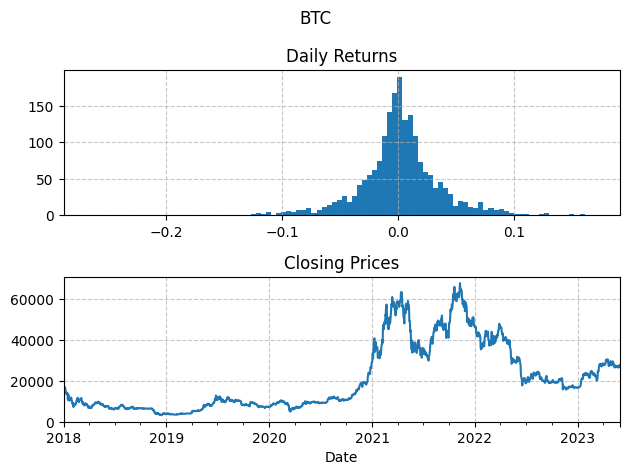

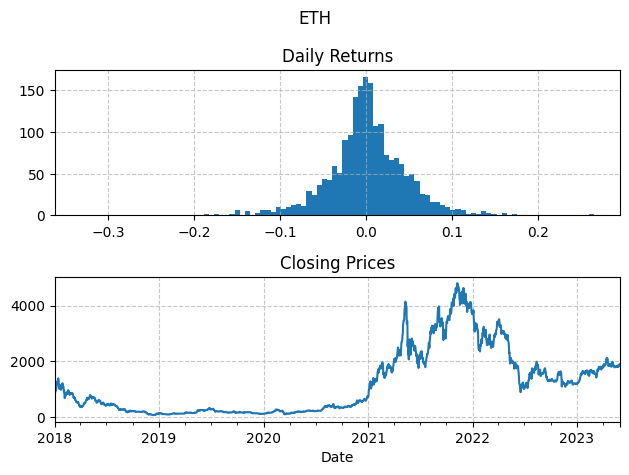

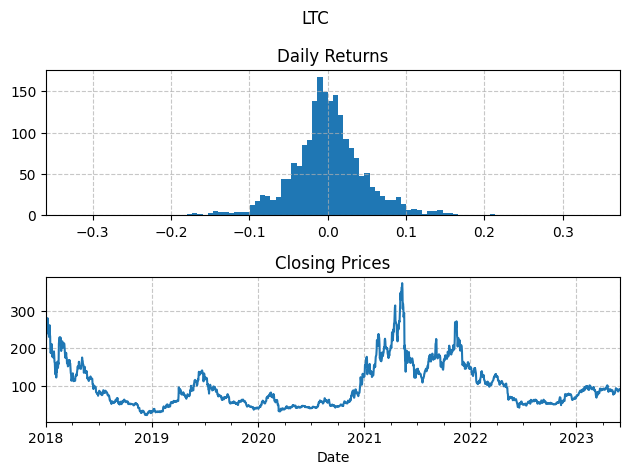

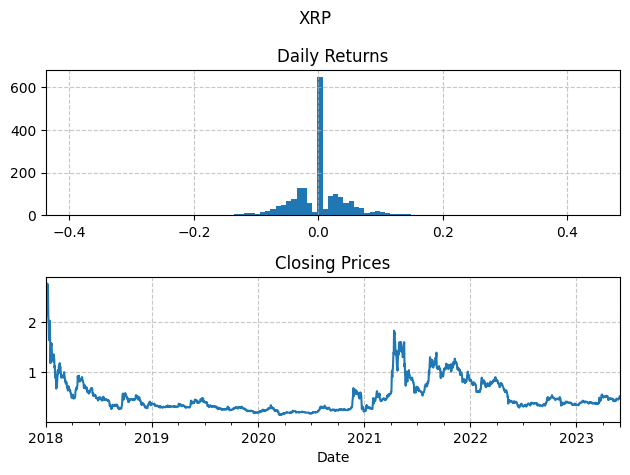

In [3]:
# Plotting the returns and prices for each coin
coins = ['BTC', 'ETH', 'LTC', 'XRP']
for coin in coins:
    coin_returns = f'{coin}__Returns'
    coin_prices = f'{coin}__Close'

    # Appending the new Returns Feature
    data[coin_returns] = data[coin_prices].pct_change()
    plot_returns_and_prices(coin, data[coin_returns], data[coin_prices])

# Droping XRP due to our concerns about data quality.
coins = ['BTC', 'ETH', 'LTC']
data = data.drop(columns=[
    'XRP__Open',
    'XRP__High',
    'XRP__Low',
    'XRP__Close',
    'XRP__Returns',
])

#### Feature selection and generation

##### Adding Technical Indicators

Predicting expectations of the future based on historical open / high / low / close / returns is quite difficult, investors often argue impossible without incorporating exogenous data. We did consider incorporating economic variables such as GDP and CPI, however, we have chosen to use technical indicators derived from historical prices for practical reasons. The indicators which we use are described below:

- **Volatility**: Also known as standard deviation, scaled by the window size of *n* days.

- **Momentum**: This indicator was developed through our own creativity and its calculation can be seen below. This indicator aims to capture how above or below the closing price is relative to the moving average and volatility.

- **RSI**: Measures the speed and magnitude of a security's recent price changes, it is used by technical traders to assess whether an asset is overbought or oversold. 

<p>Momentum = <sup>(Close - Moving Average)</sup> / <sub>(Moving Average * Volatility)</sub></p>

<p>RSI = 100 - <sup> 100</sup> / <sub>(1 + (Average Gain/ Average loss))</sub></p>


We suspect these technical indicators will provide insight into future prices, but this does come with a small cost in terms of data destruction. We considered using a custom transformer class to address the issue of missing data, however our attempts at this led to poor implementation when it comes to splitting data into training / validation / testing sets. As a result, we will simply drop the first 40 rows of data which contains missing values.

In [4]:
def calculate_rsi(prices, window=40):
    # Calculate the price differences
    delta = prices.diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the average gain and loss
    avg_gain = gain.rolling(window=window, min_periods=40).mean()
    avg_loss = loss.rolling(window=window, min_periods=40).mean()

    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

def transform_prices(prices, window=40):
    """Function to transform prices into volatility and momentum indicators."""
    features = pd.DataFrame(index=prices.index)

    # Creating the new features
    features['Returns'] = prices.pct_change()    
    features['MovingAverage'] = prices.rolling(window=window).mean()
    features['Volatility'] = features['Returns'].rolling(window=window).std() * np.sqrt(window)
    features['RSI'] = calculate_rsi(prices)

    # Creating the momentum feature
    features['Momentum'] = prices - features['MovingAverage']
    features['Momentum'] /= features['MovingAverage'] * features['Volatility']

    # Droping features which the function should not append
    features = features.drop(columns=['MovingAverage', 'Returns'])

    # Returning the new features
    return features

# Using the function to append new features to the data
for coin in coins:
    features = transform_prices(data[coin + '__Close'])
    data = pd.concat([data, features.add_prefix(f'{coin}__')], axis=1)

data = data.sort_index(axis=1)
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1937 entries, 2018-02-10 to 2023-05-31
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BTC__Close       1937 non-null   float64
 1   BTC__High        1937 non-null   float64
 2   BTC__Low         1937 non-null   float64
 3   BTC__Momentum    1937 non-null   float64
 4   BTC__Open        1937 non-null   float64
 5   BTC__RSI         1937 non-null   float64
 6   BTC__Returns     1937 non-null   float64
 7   BTC__Volatility  1937 non-null   float64
 8   ETH__Close       1937 non-null   float64
 9   ETH__High        1937 non-null   float64
 10  ETH__Low         1937 non-null   float64
 11  ETH__Momentum    1937 non-null   float64
 12  ETH__Open        1937 non-null   float64
 13  ETH__RSI         1937 non-null   float64
 14  ETH__Returns     1937 non-null   float64
 15  ETH__Volatility  1937 non-null   float64
 16  LTC__Close       1937 non-null   float64
 

The below code chunk provides a visual of our indicators. We show these charts to provide the reader with insight into how our technical indicators behave overtime.

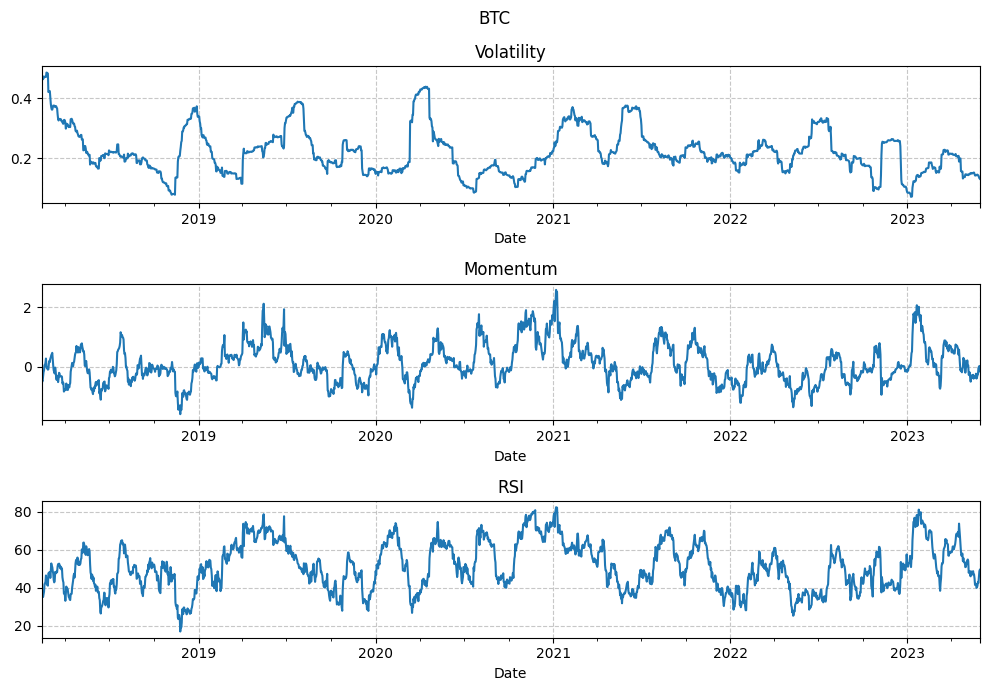

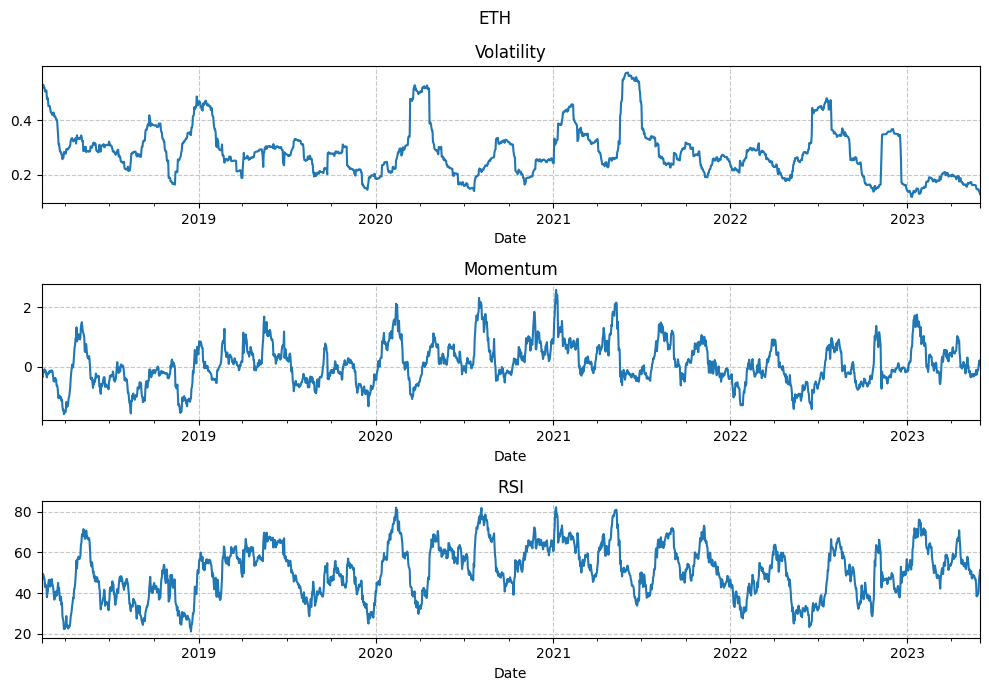

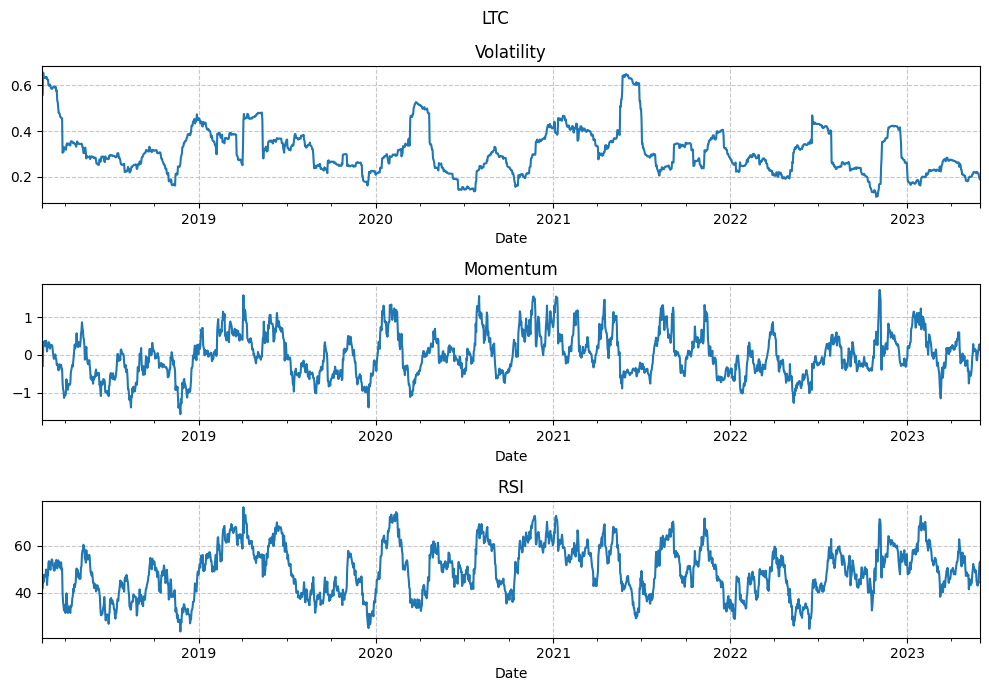

In [32]:
# Plot the technical indicators for each coin against its closing price.
figsize = (10, 7)
for coin in coins:

    # Plot the technical indicators.
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    fig.suptitle(coin)

    # Plot the volatility, momentum, and RSI of each coin.
    data[f'{coin}__Volatility'].plot(ax=ax[0], title='Volatility')
    data[f'{coin}__Momentum'].plot(ax=ax[1], title='Momentum')
    data[f'{coin}__RSI'].plot(ax=ax[2], title='RSI')

    # Apply Grids for all axs
    for axi in ax:
        axi.grid(True, alpha=0.7, linestyle='--')

    plt.tight_layout()
    plt.show()

##### Best Coin Binary Label

For our project, an especially useful feature to predict would be the coin with the highest return on t+1. The following code generates a useful target dataset of the best coin's return, and applies one hot encoding for future multi label classification.

In [6]:
# Creating a target variable dataset for future predictions
data_target = data[[f'{coin}__Returns' for coin in coins]].shift(1)
data_target = data_target.rename(columns={f'{coin}__Returns': f'{coin}__Returns_t+1' for coin in coins})

# Creating a binary target variable for each coin
best_coin_return = data_target.max(axis=1)
for coin in coins:
    data_target[f'{coin}__BestCoin'] = (data_target[f'{coin}__Returns_t+1'] == best_coin_return).astype(int)

# Dropping the missing row and realigning the data
data_target = data_target.dropna()
data = data.loc[data_target.index]

# Display the target variable dataset
data_target.head()

,BTC__Returns_t+1,ETH__Returns_t+1,LTC__Returns_t+1,BTC__BestCoin,ETH__BestCoin,LTC__BestCoin
Date,,,,,,
2018-02-11,-0.028662,-0.032552,-0.062610,1,0,0
2018-02-12,0.005321,-0.048129,-0.039544,1,0,0
2018-02-13,0.062192,0.068521,0.089218,0,0,1
2018-02-14,-0.030125,-0.028929,-0.017446,0,0,1
2018-02-15,0.083956,0.096531,0.339819,0,0,1


### 3. Model Selection and Implementation - Ryan Milgrim

#### Plotting and Analysis Functions (Optional Reading)

For our analysis / results, we have written the below section of functions to abstract away much of the mundane / reusable code to make our project more readable. If you do not want to read this section of code, please feel free to jump to the KMeans Model below.

In [7]:
# Creating a returns dataframe for analysis
returns = pd.DataFrame()
for coin in coins:
    returns[coin] = data[coin + '__Returns']

In [8]:
def analyze_regimes_and_get_best_portfolios(returns, regimes):
    """Function to print the average returns of each coin by regime and return portfolio dictionaries."""

    n_regimes = len(np.unique(regimes))
    regime_returns = returns.loc[regimes.index]

    # Print the average returns of each coin by regime and make a portfolio for each regime
    portfolios_by_regime = {}
    for i in range(n_regimes):
        average_returns = regime_returns[regimes == i].mean()

        print(f'\n-- {average_returns.idxmax()} Best coin in Regime {i}')
        print(average_returns)

        # Add the best portfolio for this regime to the dictionary
        best_coin_index = average_returns.idxmax()
        portfolios_by_regime[i] = [1 if coin == best_coin_index else 0 for coin in average_returns.index]

    # Also print out the best coin overall
    overall_average_returns = returns.mean()
    print(f'\n-- Best Coin Overall: {overall_average_returns.idxmax()}')

    # Create the best overall portfolio
    best_coin_index = overall_average_returns.idxmax()
    best_overall_portfolio = [1 if coin == best_coin_index else 0 for coin in overall_average_returns.index]
    best_overall_portfolio = {i: best_overall_portfolio for i in range(n_regimes)}

    return portfolios_by_regime, best_overall_portfolio

In [9]:
def create_portfolio_timeseries(regimes, portfolio_dict, coins):
    """Function to create a portfolio timeseries from a regime timeseries and portfolio dictionary"""

    # Create a portfolio timeseries
    portfolio = pd.DataFrame(np.zeros((len(regimes), len(coins))), index=regimes.index, columns=coins)
    for regime, allocation in portfolio_dict.items():
        portfolio[regimes == regime] = allocation

    return portfolio

In [10]:
def plot_portfolio_backtest(portfolio, benchmark, returns):
    """Function to plot the cumulative returns of a portfolio and its allocation over time"""

    # Calculate the cumulative returns of the portfolio and benchmark
    portfolio_returns = np.sum(returns * portfolio, axis=1)
    benchmark_returns = np.sum(returns * benchmark, axis=1)

    # Create the figure and axis
    fig, ax = plt.subplots(2, 1, figsize=(8, 5))

    # Plot the cumulative returns of the portfolio and benchmark
    ax[0].set_title('Cumulative Returns')
    (1 + portfolio_returns).cumprod().plot(ax=ax[0], label='Portfolio')
    (1 + benchmark_returns).cumprod().plot(ax=ax[0], label='Benchmark', linestyle='--')
    ax[0].grid(True, alpha=0.7, linestyle='--'), ax[0].legend()

    # Plot the rolling 30-day volatility of the portfolio and benchmark
    ax[1].set_title('Rolling 30-Day Volatility')
    portfolio_returns.rolling(window=30).std().plot(ax=ax[1], label='Portfolio')
    benchmark_returns.rolling(window=30).std().plot(ax=ax[1], label='Benchmark', linestyle='--')
    ax[1].grid(True, alpha=0.7, linestyle='--'), ax[1].legend()

    plt.tight_layout()
    plt.show()

    # Print out simple Sharpe ratio metrics
    portfolio_sharpe = portfolio_returns.mean() / portfolio_returns.std()
    benchmark_sharpe = benchmark_returns.mean() / benchmark_returns.std()
    print('\nSharpe Ratio:')
    print(f'Model: {portfolio_sharpe:.4f}')
    print(f'Benchmark: {benchmark_sharpe:.4f}')

    # Create a plot function which plots the portfolio allocations over time
    if portfolio_sharpe > benchmark_sharpe:
        print('Model Outperformed the benchmark.')
    else:
        print('Model Failed to beat the benchmark.')

In [11]:
def plot_portfolio_allocations(portfolio, benchmark):

    # Create the figure and axis
    fig, ax = plt.subplots(2, 1, figsize=(8, 5))
    fig.suptitle('Model and Benchmark Allocations')

    # Plot the portfolio allocation
    portfolio.plot(ax=ax[0], kind='area', stacked=True)   
    ax[0].set_ylim((0, 1)), ax[0].set_ylabel('Portfolio'), ax[0].legend()
    ax[0].grid(True, alpha=0.7, linestyle='--')

    # Plot the portfolio allocation without x or y axis labels
    benchmark.plot(ax=ax[1], kind='area', stacked=True)
    ax[1].set_ylim((0, 1)), ax[1].set_ylabel('Benchmark'), ax[1].legend()
    ax[1].grid(True, alpha=0.7, linestyle='--')

    plt.tight_layout()
    plt.show()

#### KMeans Persistent Regime Model - Ryan Milgrim

The KMeans model is a simple clustering algorithm which is often used to classify a timer’s series according to regimes. It is reasonable to believe that coins might perform better or worse within these regime classifications. Additionally, if our regime classifications are persistent, that we have a low chance of transitioning out of the current regime, then it would be reasonable to invest a portfolio according to the regimes predicted on the training set. Of course, we will need to shift our portfolios 1 day to reflect a t+1 prediction. 


##### Data Splitting

Currently, we have no hyper parameters to tune, which means our data may be split into a 60% training set and 40% testing set. We are working with timeseries data, so we will not shuffle the data. 


In [12]:
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

# Create an X dataset with only the technical indicators for regime detection (Our most persistent features)
technical_indicators = [coin + '__Momentum' for coin in coins]
technical_indicators += [coin + '__Volatility' for coin in coins]
X = data[technical_indicators]

# Split the data into training and testing sets
X_train, X_test = train_test_split(X, shuffle=False, test_size=0.4)

##### Build Model

KMeans benefits from data scaling, and I would like to introduce the RobustScaler Class as I have found it useful in reducing our sensitivity to outliers. It is quite common to find outliers in financial data, I would cite the economic turmoil of March 2022 as a period where a robust scaler may yield superior results over a StandardScaler.

To determine the optimal number for clusters, we fit kmeans from 2 through 10 for n_clusters. Reviewing the silhouette scores, it appears that only 2 regimes is optimal. 

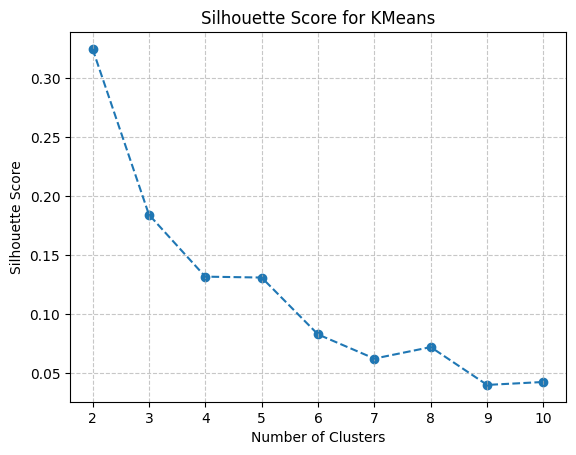

In [13]:
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler

# Create the pipeline to only momentum and volatility columns
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('kmeans', KMeans(n_init=10, random_state=42))
])


# Fit the pipeline to the for n_clusters = {2 - 10} and record silhouette score.
scores = dict()
for n in range(2, 11):
    pipeline.set_params(kmeans__n_clusters=n)
    pipeline.fit(X_train)
    
    # Transform data to get cluster labels
    labels = pipeline['kmeans'].labels_

    # Calculate the silhouette score
    score = silhouette_score(X_train, labels)
    scores[n] = score

# Refitting the model to our best found parameter
n_regimes = 2
pipeline.set_params(kmeans__n_clusters=n_regimes)
pipeline.fit(X_train)

# Plot the scores
fig, ax = plt.subplots()
ax.plot(list(scores.keys()), list(scores.values()), linestyle='--')
ax.scatter(list(scores.keys()), list(scores.values()))
ax.set_title('Silhouette Score for KMeans')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')
ax.grid(True, alpha=0.7, linestyle='--')
plt.show()


As discussed in our reasoning, we should hope that the coins behave differently by regime. To visualize this, we plot the below histograms. 

The first observation does appear to be that there is a strong correlation between the returns of the coins, although this is not very shocking. However, it does appear that KMeans clusters our coins in a way where one regime has positive returns, and the other has negative returns. It could be quite easy to label these regimes as either “Bull” or “Bear” regimes. In the Bull regime, I would choose to hold ETH and in the Bear regime I would rather hold BTC.

Now, if these regimes have persistence, and there is an association between these regimes and the expected return of a coin, then perhaps our model will be effective on unseen data.  



Days In:
Regime 0: 940
Regime 1: 996

Percentage of Time in:
Regime 0: 48.55%
Regime 1: 51.45%

Transition Matrix:
col_0         0         1
row_0                    
0.0    0.955272  0.044728
1.0    0.043173  0.956827


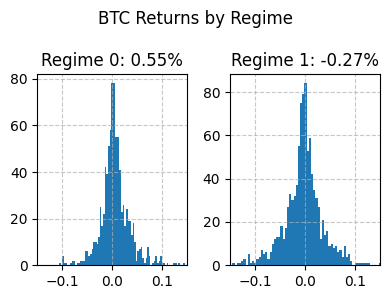

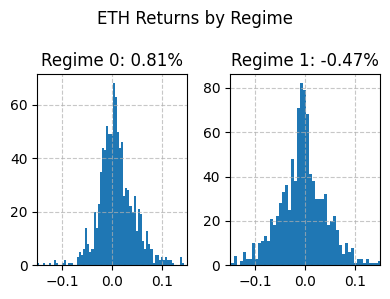

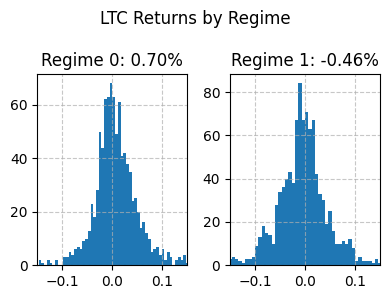

In [14]:
# Assigning a regimes timeseries
regimes = pd.Series(pipeline.predict(X), data.index)
for coin in coins:

    fig, axs = plt.subplots(1, n_regimes, figsize=(2 * n_regimes, 3))
    fig.suptitle(f'{coin} Returns by Regime')

    # Plot a histogram of each regime with the mean return in the title
    for i in range(n_regimes):

        # Filtering down to the coin's returns within the regime
        regime_returns = data.loc[regimes == i, f'{coin}__Returns']

        # Plotting the histogram
        regime_returns.hist(bins=100, ax=axs[i])
        axs[i].set_title(f'Regime {i}: {regime_returns.mean():.2%}')
        axs[i].grid(True, alpha=0.7, linestyle='--')
        axs[i].set_xlim((-0.15, 0.15))

    plt.tight_layout()

# Print the number of days in each regime
print('\nDays In:')
for i in range(n_regimes):
    print(f'Regime {i}: {regimes.value_counts()[i]}')

# Print the percentage of time in each regime
print('\nPercentage of Time in:')
for i in range(n_regimes):
    print(f'Regime {i}: {regimes.value_counts(normalize=True)[i]:.2%}')

# Print a transition matrix. The probability of transitioning from regime a to b
transition_matrix = pd.crosstab(regimes.shift(), regimes, normalize='index')
print('\nTransition Matrix:')
print(transition_matrix)

To better understand the clustering, we plot the cluster centers with the inverse transformation method. We see that the regimes are mostly clustered according to positive or negative momentum and the negative momentum regime experiences slightly more volatility. 

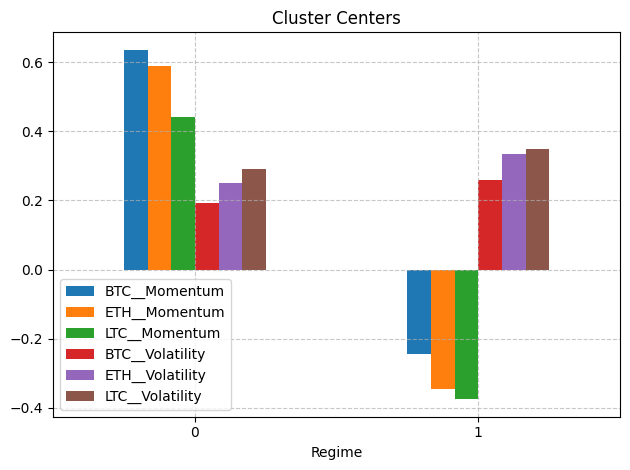

In [15]:

centers = pipeline['kmeans'].cluster_centers_
centers = pd.DataFrame(pipeline['scaler'].inverse_transform(centers), columns=technical_indicators)
centers.index.name = 'Regime'

fig, ax = plt.subplots()
centers.plot(kind='bar', ax=ax)
plt.title('Cluster Centers')
plt.grid(True, alpha=0.7, linestyle='--')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


By using the transition matrix, we can see that the regimes are persistent in both the training set and testing sets.

In [16]:
# Use the pipeline to predict both training and test sets.
regimes_train = pd.Series(pipeline.predict(X_train), X_train.index)
regimes_test = pd.Series(pipeline.predict(X_test), X_test.index)

# Print the transition matrix of the regime training set
transition_matrix = pd.crosstab(regimes_train.shift(1), regimes_train, normalize='index')
print('\nTraining Transition Matrix:')
print(transition_matrix)

# Print the transition matrix of the regime test set
transition_matrix = pd.crosstab(regimes_test.shift(1), regimes_test, normalize='index')
print('\nTest Transition Matrix:')
print(transition_matrix)




Training Transition Matrix:
col_0         0         1
row_0                    
0.0    0.958106  0.041894
1.0    0.039280  0.960720

Test Transition Matrix:
col_0         0         1
row_0                    
0.0    0.951157  0.048843
1.0    0.049351  0.950649


##### Back Testing

This function prints the best coin to hold by regime. It appears we should hold BTC in regime 0 and ETH in regime 1. 

In [17]:
portfolios, _ = analyze_regimes_and_get_best_portfolios(returns, regimes_train)


-- ETH Best coin in Regime 0
BTC    0.007034
ETH    0.009450
LTC    0.008427
dtype: float64

-- BTC Best coin in Regime 1
BTC   -0.001699
ETH   -0.004581
LTC   -0.003872
dtype: float64

-- Best Coin Overall: ETH


Applying the same function to our testing data, we obtain the benchmark portfolio. ETH is the best coin overall so it is the only coin the benchmark holds.

In [18]:
# During the testing period, ETH was the best overall coin. So our benchmark to beat is a 100% allocation to ETH during the testing period.
_, benchmark = analyze_regimes_and_get_best_portfolios(returns, regimes_test)


-- ETH Best coin in Regime 0
BTC    0.003453
ETH    0.006279
LTC    0.005022
dtype: float64

-- BTC Best coin in Regime 1
BTC   -0.004414
ETH   -0.004972
LTC   -0.005835
dtype: float64

-- Best Coin Overall: ETH


In [19]:
# Formatting our portfolios into a timeseries. Also shifting the portfolios by one day so they may be investable. 
portfolios = create_portfolio_timeseries(regimes_test, portfolios, coins).shift(1)
benchmark = create_portfolio_timeseries(regimes_test, benchmark, coins)

# Also make a set of returns for the backtest
returns_test = benchmark.align(returns, join='inner')[1]


The model has incredibly positive results.

The model does an excellent job at timing when we should be holding BTC vs ETH, and this can be seen in the back test below. The model outperforms the best performing coin in the testing period, ETH, and does so with less volatility. These two metrics mean that our simplistic coin timing model may help a portfolio manager choose which coin is better to hold based on the current moment and volatility of the coins alone. This means that our model’s allocation could be clearly articulated to an investor with the follow:

**Our model has two regimes, bull and bear. These regimes are classified according to momentum and volatility, and we alter our allocation based upon the current level of these indicators. Right now, we are in a bull regime with strong momentum, thus we are allocating to ETH over BTC.**

A simple description like this is critical to investors who will require an explication of their strategy to their investors. This simple and transparent answer is unbelievably valuable. 


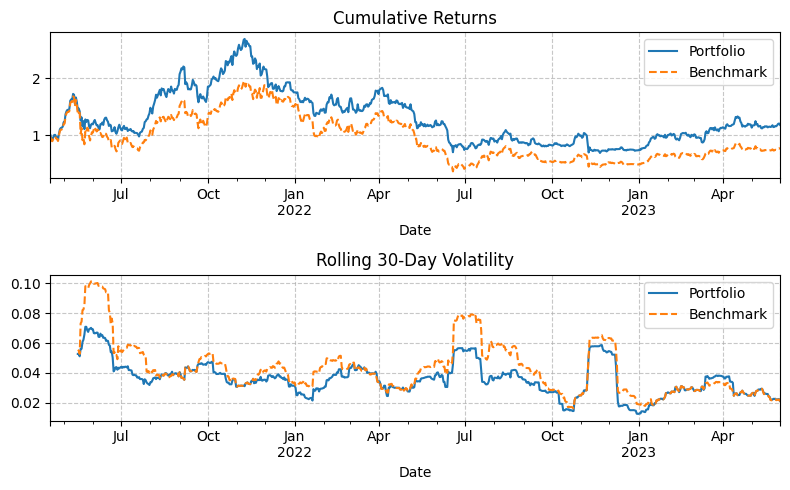


Sharpe Ratio:
Model: 0.0247
Benchmark: 0.0151
Model Outperformed the benchmark.


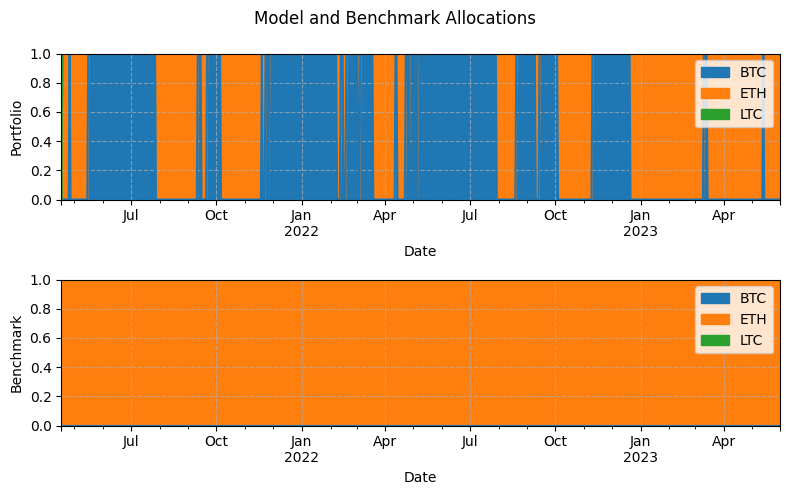

In [20]:
# Plot the portfolio returns and allocation
plot_portfolio_backtest(portfolios, benchmark, returns_test)
plot_portfolio_allocations(portfolios, benchmark)

#### DNN Model - Ryan Milgrim

During lecture 14 we learned about the softmax activation and its use in multi label classification. <a href="https://en.wikipedia.org/wiki/Softmax_function">Softmax's</a> activation function is shown below:

<p>σ(z<sub>i</sub>) = <sup>exp(z<sub>i</sub>)</sup> / <sub>Σ exp(z<sub>j</sub>)</sub></p>


This function has two unique features, the first is that the sum of all activations, σ(z<sub>i</sub>), will be equal to 100% and it is impossible for any neuron to have a negative value. These features are of course by design, as SoftMax’s output is a probability distribution, more specifically, the Categorical distribution. These properties are typical portfolio constraints, allocations of coins must equal 100% reflecting full investment and are constrained to long only positions. 

As a result of these features, SoftMax is a popular choice of output layer for what academics have been calling “End to End” neural networks for portfolio management. With our model, we will be able to simply call predict(X_test) to receive our portfolios using this “End to End” approach.<a href="[2111.09170] A Universal End-to-End Approach to Portfolio Optimization via Deep Learning (arxiv.org)"> Reference for End to End portfolio management here.</a>

Of course, there are unanswered questions surrounding the number of layers, neurons per layer, activation, and dropout. We will use the HyperBand tuner for hyper tuning and report the best-found parameters. We will search for activation functions (relu or swish), dropout, l2 regularization, and learning rate as well. The model will be optimized using the NADAM optimizer with 2 different learning rates over 2 full iterations. 

##### Data Splitting

We again split the data into 60% training and 40% testing. With hyper tuning, we will further split the data into a training and validation set using 80% training and 20% for validation. Because this is timeseries data, we will set shuffle to False when training the model. 


In [21]:
# Suppress warnings from tensorflow
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Define the features and target variable
y = data_target[[col for col in data_target.columns if 'BestCoin' in col]]
X = data.copy()

# Split X and y into training and testing sets
X_train_full, X_test = train_test_split(X, shuffle=False, test_size=0.4)
y_train_full, y_test = train_test_split(y, shuffle=False, test_size=0.4)

# Further split the training set into training and validation sets
X_train, X_val = train_test_split(X_train_full, shuffle=False, test_size=0.2)
y_train, y_val = train_test_split(y_train_full, shuffle=False, test_size=0.2)

# Display the training set
print(y_train.shape)
print(X_train.shape)
y_train.head()

(928, 3)
(928, 24)


,BTC__BestCoin,ETH__BestCoin,LTC__BestCoin
Date,,,
2018-02-11,1,0,0
2018-02-12,1,0,0
2018-02-13,0,0,1
2018-02-14,0,0,1
2018-02-15,0,0,1


##### Hypertuning 

It is important to note, this model does include **l2 regularization** which is how we can implement feature selection in our model. 

In [22]:
import tensorflow as tf
from kerastuner.tuners import Hyperband

# Define the model-building function
def build_model(hp):

    # Creating the hyperparameters to tune
    num_layers = hp.Int('num_layers', min_value=1, max_value=5)
    num_units = hp.Int('num_units', min_value=4, max_value=24, step=8)
    activation = hp.Choice('activation', values=['relu', 'swish'])
    l2_regularizer = hp.Float('l2_regularizer', 0.05, 0.25, step=0.05)
    dropout = hp.Float('dropout', 0.10, 0.5, step=0.10)
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-4])

    # Start the model with a batch normalization layer
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]))
    
    # Add hidden layers
    for i in range(num_layers):

        # Add a dense layer with L2 regularization and an activation function (relu or swish)
        model.add(tf.keras.layers.Dense(
            num_units,activation=activation,
            kernel_regularizer=tf.keras.regularizers.l2(l2_regularizer)
        ))

        # Add a batch normalization layer
        model.add(tf.keras.layers.BatchNormalization())

        # Add a dropout layer after each dense layer
        model.add(tf.keras.layers.Dropout(dropout))

    # Add the output layer with a softmax activation function
    model.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))

    # Compile the model with a Nadam optimizer with accuracy as the metric
    model.compile(
        optimizer=tf.keras.optimizers.Nadam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define the tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy', # Optimize the out of sample validation accuracy
    hyperband_iterations=1, # Perform 3 hyperband iterations
    directory='CoinTuners',
    project_name='DNN',
    seed=42
)

# Begin the search for the best hyperparameters. Do not shuffell the data
tuner.search(X_train, y_train, validation_data=(X_val, y_val), shuffle=False)

# print the best hyperparameters
print("\n--- Best Hyperparameters ---")
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
for i, key in enumerate(best_hps.values.keys()):
    print(f"{key}: {best_hps.values[key]}")


C:\Users\ryanm\AppData\Local\Temp\ipykernel_22476\822644794.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


Reloading Tuner from CoinTuners\DNN\tuner0.json

--- Best Hyperparameters ---
num_layers: 1
num_units: 12
activation: relu
l2_regularizer: 0.05
dropout: 0.1
learning_rate: 0.01
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0142


Here we can see a summary of our hypertuned model. 

In [23]:
# Get the best model and refit on the entire training set
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

c:\Users\ryanm\anaconda3\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\ryanm\anaconda3\Lib\site-packages\keras_tuner\src\tuners\hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
c:\Users\ryanm\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'nadam', becaus

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 24)             │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12)             │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            39 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 483 (1.89 KB)

 Trainable params: 411 (1.61 KB)

 Non-trainable params: 72 (288.00 B)

##### Refitting and Learning Curves

Now that we have tuned the model and found the above hyperparameters, we refit the model to the full training set. To summarize what I am finding, I notice that the model is highly unstable and the results are not consistent as I refit the model. Reviewing the learning curves, the out of sample metrics are noisy (moving above / below the insample at each epoch). This variance in validation accuracy is a sign of overfitting despite my use of l2 regularization and the relativly simple model obtained via hyper tuning.  

For this reason, the next model will incorporate a walk forward optimization which will hopefully improve our model via superior cross validation of timeseries data and reduce our chance of overfitting. 

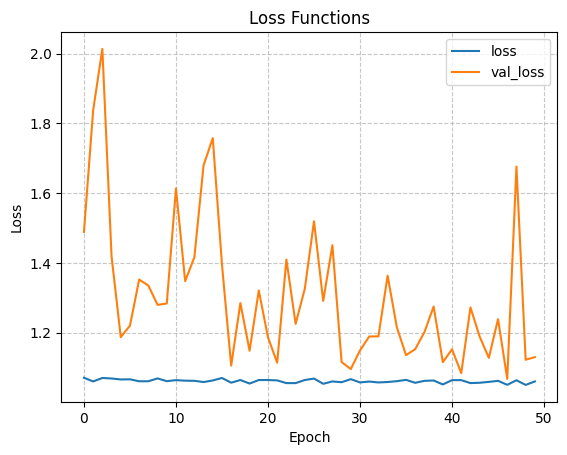

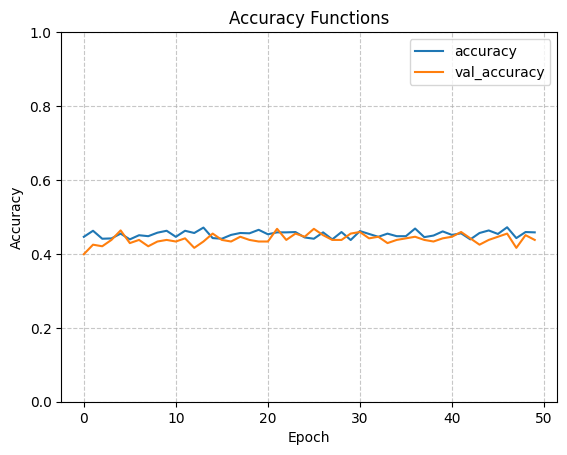

BTC Probability: 34.06%
ETH Probability: 34.58%
LTC Probability: 31.35%


In [24]:
# Refit the model to the training set 
history = best_model.fit(X_train_full, y_train_full, epochs=50, validation_data=(X_val, y_val), shuffle = False, verbose=0)
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(xlabel="Epoch", ylabel="Loss", title="Loss Functions")
plt.grid(True, alpha=0.7, linestyle='--')
plt.show()

# Plot the accuracy functions
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(
    ylim=(0, 1), xlabel="Epoch", ylabel="Accuracy", title="Accuracy Functions")
plt.grid(True, alpha=0.7, linestyle='--')
plt.show()

# Print the best coin probabilities as noted in the above paragraph
coin_probability = y_test.sum() / len(y_test)
for i, coin in enumerate(coins):
    print(f'{coin} Probability: {coin_probability.iloc[i]:.2%}')

##### Back Testing

As we previously mentioned, this model appears to be overfitting despite its ability to attain an accuracy score above 40%. When reviewing the model summary, the model we selected was one of the least complex models in terms of number of layers and number of neurons, another sign that our model is likely overfitting to the data. 

In addition, I notice that each time I refit the model, the time series of allocations changes rather significantly, I refit the model twice to prove this below. This is an extremely negative trait to have in a portfolio construction method and as a result, I consider this model to be a failure despite my efforts. 

I believe this stability problem is the result of using a dropout layer which introduces a stochastic element to the model’s training. Perhaps this would be a reasonable feature if we had more data available, but a limited history is one of the defining traits of crypto currency markets. In future research, perhaps one might consider using a GAN (General Adversarial Network) to generate fake versions of history which may be used to supplement the model’s training. 

Overall, I have found that I dislike using a DNN to generate an "End to End" model. I previously noted how easy it was to explain the KMeans output to an investor, this approach yields what I consider to be a black box output with almost 0% explainability. Even if the model was performing well, I personally would not quite feel confortable investing in it due this lack of explainability. 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


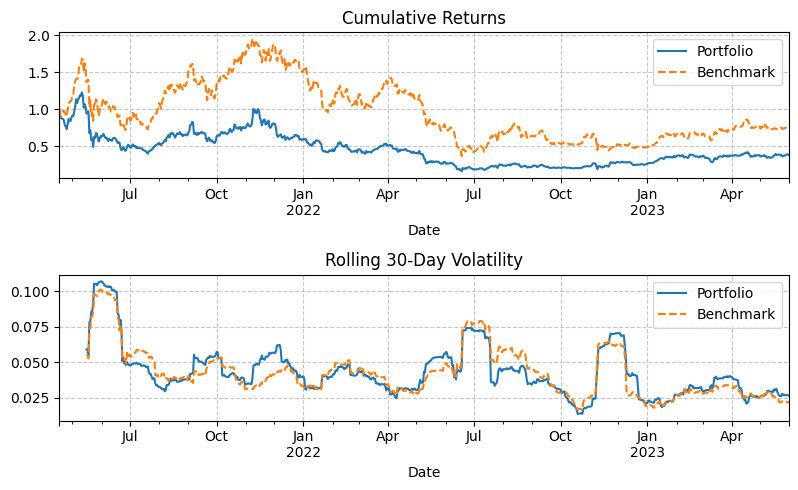


Sharpe Ratio:
Model: -0.0036
Benchmark: 0.0151
Model Failed to beat the benchmark.


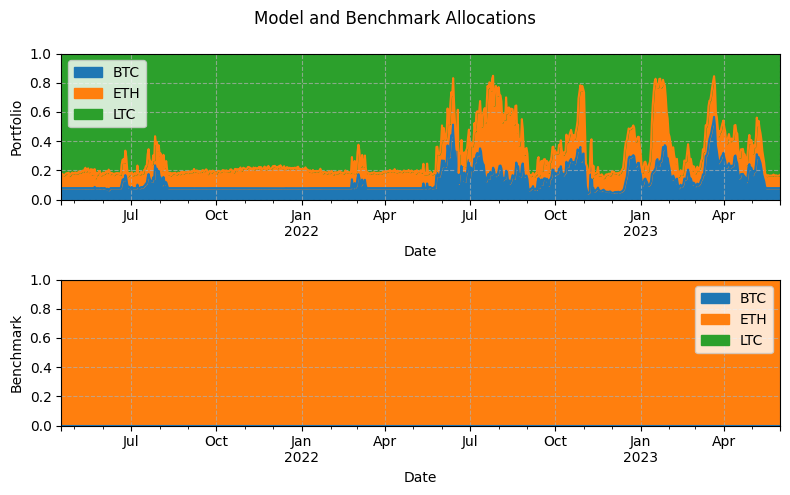

In [25]:
dnn_portfolios_softmax = pd.DataFrame(best_model.predict(X_test), index=X_test.index, columns=coins)

# Plot the portfolio returns and allocation
plot_portfolio_backtest(pd.DataFrame(dnn_portfolios_softmax, index=X_test.index, columns=coins), benchmark, returns_test)
plot_portfolio_allocations(pd.DataFrame(dnn_portfolios_softmax, index=X_test.index, columns=coins), benchmark)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step


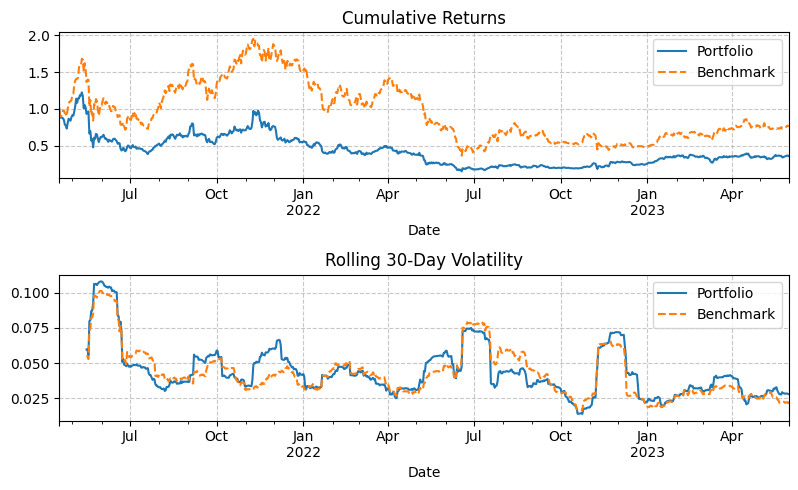


Sharpe Ratio:
Model: -0.0046
Benchmark: 0.0151
Model Failed to beat the benchmark.


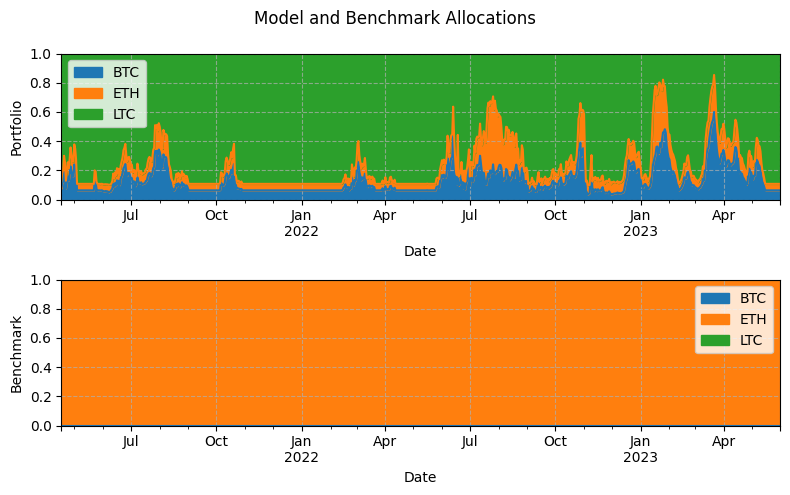

In [26]:
history = best_model.fit(X_train_full, y_train_full, epochs=100, validation_data=(X_val, y_val), shuffle = False, verbose=0)
dnn_portfolios_softmax = pd.DataFrame(best_model.predict(X_test), index=X_test.index, columns=coins)

# Plot the portfolio returns and allocation
plot_portfolio_backtest(pd.DataFrame(dnn_portfolios_softmax, index=X_test.index, columns=coins), benchmark, returns_test)
plot_portfolio_allocations(pd.DataFrame(dnn_portfolios_softmax, index=X_test.index, columns=coins), benchmark)

#### Random Forest Regressor with Walkforward Optimization - Ryan Milgrim

So far, we have trained a simple KMeans model and a complex DNN to generate our portfolios. Now I would like to predict tomorrow’s return with an intermediate complexity model, the RandomForestRegressor.

The reason I am choosing a Random Forest Regressor for this attempt, is that I felt the DNN was poor due to limited training data. Random Forests are known to require materially less data than neural networks, and in addition, are also particularly good at accounting for nonlinear trends often seen within financial data. Furthermore, the insight provided by the feature importance attribute adds a tremendous amount of explainability to the model.

##### Splitting

This model will make use of the Gold Standard in time series cross validation, walk forward optimization. We will again be using a 60% 40% split without shuffling, and this time we will make use
of the TimeSeriesSplit class provided by Sklean in addition to GridSearchCV for  cross validation and hypertuning. 


In [27]:
# Define the features and target variable
y = data_target[[col for col in data_target.columns if 'Returns_t+1' in col]]
X = data.copy()

# Split X and y into training and testing sets
X_train, X_test = train_test_split(X, shuffle=False, test_size=0.4)
y_train, y_test = train_test_split(y, shuffle=False, test_size=0.4)

# Display the training set
print(y_train.shape)
print(X_train.shape)
y_train.head()

(1161, 3)
(1161, 24)


,BTC__Returns_t+1,ETH__Returns_t+1,LTC__Returns_t+1
Date,,,
2018-02-11,-0.028662,-0.032552,-0.062610
2018-02-12,0.005321,-0.048129,-0.039544
2018-02-13,0.062192,0.068521,0.089218
2018-02-14,-0.030125,-0.028929,-0.017446
2018-02-15,0.083956,0.096531,0.339819


##### Hypertuning and Fitting

Below you can find our parameter grid. The following code implements a cross validated gridsearch using a walk forward optimization strategy. 

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Define the parameter grid
param_grid = {
    'n_estimators': [25, 50, 100, 150, 200],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 4, 8, 10]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    RandomForestRegressor(),
    param_grid,
    cv=TimeSeriesSplit(n_splits=10),
    n_jobs=-1,
    verbose=1
)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# print the best hyper parameters
print("\n--- Best Hyperparameters ---")
for parameter in grid_search.best_params_:
    print(f"{parameter}: {grid_search.best_params_[parameter]}")

Fitting 10 folds for each of 500 candidates, totalling 5000 fits

--- Best Hyperparameters ---
max_depth: 4
min_samples_leaf: 10
min_samples_split: 4
n_estimators: 150


##### Back Testing

This model yields an expectation of return for each coin, as a result I have included additional charts displaying our forward looking 1 day return prediction. I am a very big fan of these charts as they greatly improve the model's explainability.

The back test looks quite good, and the model was able to outperform our benchmark in terms of sharpe ratio and did so by purchasing all 3 coins. This appears to be a very promising model. 

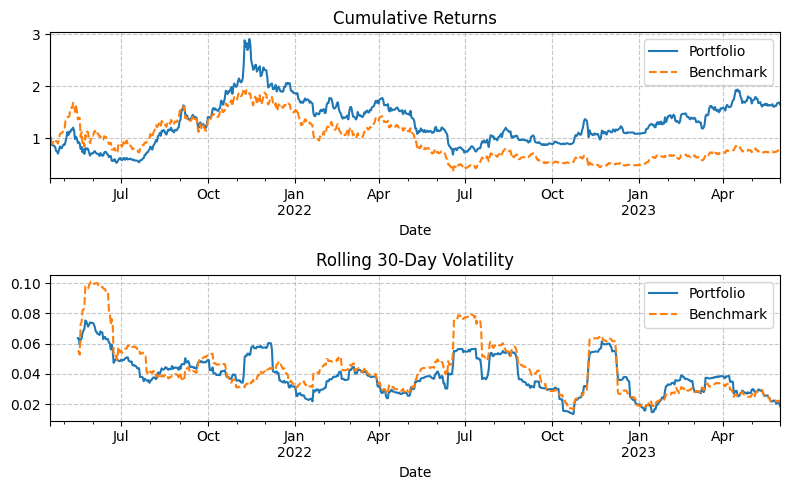


Sharpe Ratio:
Model: 0.0364
Benchmark: 0.0151
Model Outperformed the benchmark.


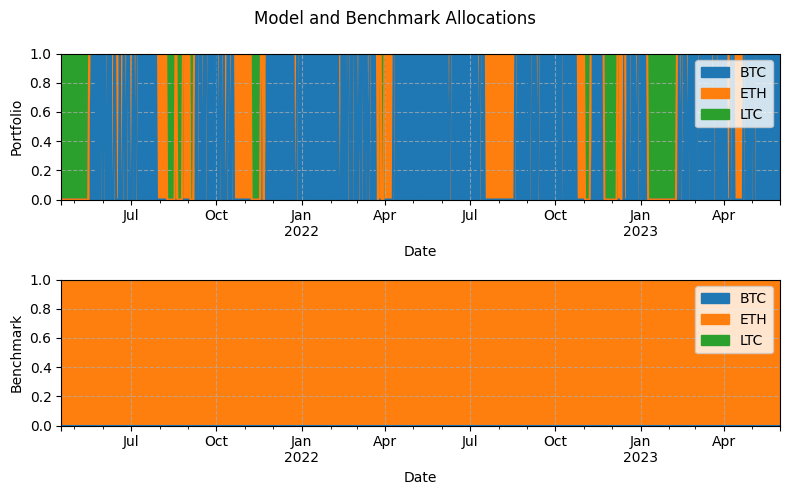

In [29]:
y_pred = pd.DataFrame(grid_search.predict(X_test), index=X_test.index, columns=coins)

# Creating the hardmax strategy from the softmax strategy
best_coin_pred = y_pred.idxmax(axis=1)
rf_portfolios = pd.DataFrame(0, index=X_test.index, columns=coins)
for coin in coins:
    rf_portfolios[coin] = (best_coin_pred == coin).astype(int)

plot_portfolio_backtest(rf_portfolios, benchmark, returns_test)
plot_portfolio_allocations(rf_portfolios, benchmark)



By inspecting the the features, we can see that the momentum of each coin plays a large driver in the predicted value, followed by the coin's return on the previous day then its volatility. Knowing this, I can more confidently say that our allocation reflects a momentum approach when building our forward looking expections which goes a long way in terms of explainability. 

In [30]:
# Print the most important features
feature_importances = pd.Series(grid_search.best_estimator_.feature_importances_, index=X_train.columns)
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances.head(10)

LTC__Momentum      0.299124
BTC__Momentum      0.171330
LTC__Returns       0.116633
ETH__Momentum      0.072565
BTC__Returns       0.068792
ETH__Volatility    0.045651
BTC__RSI           0.032126
LTC__Volatility    0.030146
ETH__Returns       0.029857
ETH__RSI           0.022548
dtype: float64

Below I have plotted the residual, actual, and predicted values for each coin. Again, this lets us perform deeper analysis into our model which the "End to End" approach did not let us perform. To summarize the results here, our predictions are quite stable overtime despite a very noisy return time series. We do manage to reduce the variance of the actual values vs our residuals, just barely, but this is actually quite good considering our target is the return of a cryptocurrency at t+1. 


BTC Residual vs Actual:
Std of Residuals: 0.033772
Std of Actual Returns: 0.034842
Variability Ratio: 0.969281


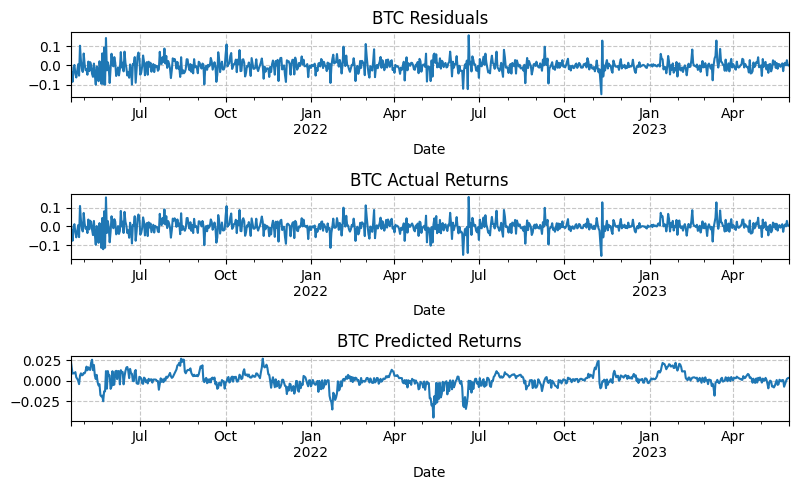


ETH Residual vs Actual:
Std of Residuals: 0.043909
Std of Actual Returns: 0.045611
Variability Ratio: 0.96269


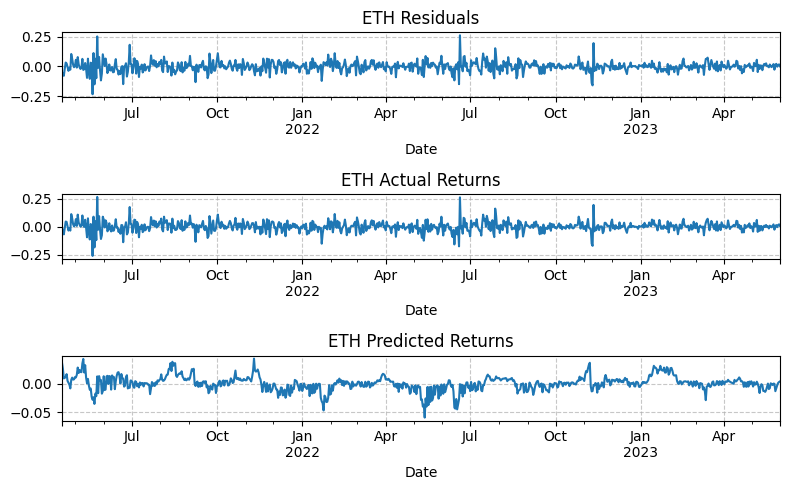


LTC Residual vs Actual:
Std of Residuals: 0.047101
Std of Actual Returns: 0.049239
Variability Ratio: 0.956583


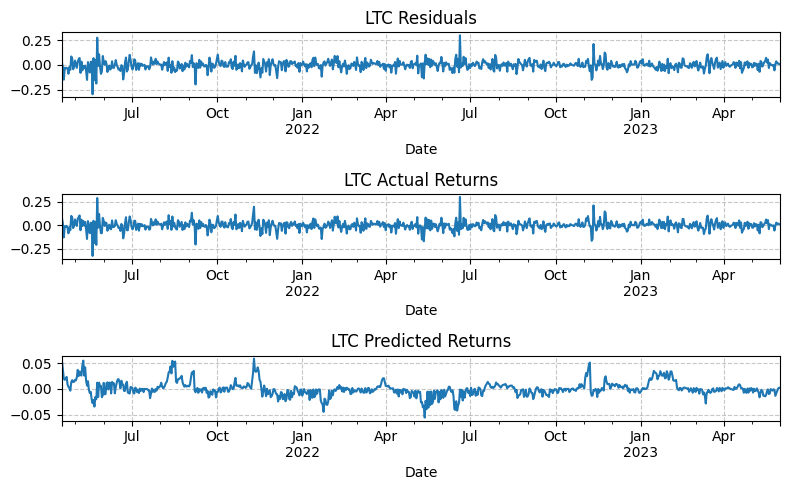

In [31]:

# Calculate the residuals
residuals = pd.DataFrame(y_test.to_numpy() - y_pred.to_numpy(), index=y_test.index, columns=coins)

for coin in coins:

    # Create the figure and axis
    fig, ax = plt.subplots(3, 1, figsize=(8, 5))

    # Plot the residuals of the model
    resid = residuals[coin]
    residuals[coin].plot(title=f'{coin} Residuals', ax=ax[0])
    ax[0].grid(True, alpha=0.7, linestyle='--')


    # Plot the actual returns of the coin
    actual = y_test[coin + '__Returns_t+1']
    actual.plot(title=f'{coin} Actual Returns', ax=ax[1])
    ax[1].grid(True, alpha=0.7, linestyle='--')

    # Plot the return prediction of the coin
    y_pred[coin].plot(title=f'{coin} Predicted Returns', ax=ax[2])
    ax[2].grid(True, alpha=0.7, linestyle='--')

    # Print the standard deviation of the residuals and actual returns
    print(f'\n{coin} Residual vs Actual:')
    print('Std of Residuals:', round(resid.std(), 6))
    print('Std of Actual Returns:', round(actual.std(), 6))
    print('Variability Ratio:', round(resid.std() / actual.std(), 6))

    plt.tight_layout()
    plt.show()

### Analysis Summary - Ryan Milgrim

We implemented three different approaches to portfolio construction. A simple KMeans regime persistence model, a complex end to end deep neural network, and a random forest regressor for t+1 return expectations. As a takeaway, our goal was to provide investors with tools which they might use to make more informed decisions when investing in crypto currency markets for maximum return. I would say two of our models achieved this, the KMeans model and the Random Forest Regressor.

The strength of the KMeans and Random Forest model, in my opinion, is that they require less data before they are able to generalize well. This is a common issue in financial time series, which can hinder more data intensive models like a deep neural network. In addition, both models had remarkable explainability, enough for me to clearly say that their success was driven from the technical indicator we defined as momentum. As a result, my primary message to investors who are interested in generating outsized returns within the crypto currency markets, is that strategies with an emphasis on momentum should be strongly considered. I will admit, I find this discovery to be unsurprising. The brief history we have of cryptocurrencies has shown strong signals of trend in my anecdotal research, however, our analysis has not yet accounted for liquidity. Each of our strategies assumed there was no spread between the bid and asking price of our coins, we know this is not true so if an investor were to follow our portfolios, they may yet incur trading costs more significant the returns of our back tests. 

The end-to-end DNN model was unfortunately a failure. The first clue was seen during the tuning process where the tuner’s search resulted in models which favored much lower degrees of complexity than allowed. Additionally, when trained the model had a very noisy accuracy curve compared to the training curve, this out of sample validation variance was our next sign of overfitting. In addition, the inclusion of dropout appears to be a poor decision, as I previously noted, this made the model unstable when fitting which is not a good trait. With these issues alone, I would call my model a poor tool for portfolio management, however I would like to address the topic of “end to end” machine learning for portfolio management which I previously cited. 

I do find the architecture of end-to-end models interesting for portfolio management. To review, existing portfolio theory stems from Howard Markowitz’s work covering portfolio selection and mean variance optimization.  End to end models challenge Markowitz’s approach to portfolio selection by removing the need to forecast expectations of returns, volatilities, and correlations. By removing this step, end to end models argue that they have reduced their sensitivity to forecast error. Additionally, end to end models can be optimized to superior risk metrics, semi variance for example. Semi variance is a superior risk metric to variance as it is asymmetric and will not punish portfolios for positive performance, however, it may only be optimized through black box optimizers like SGD or NADAM. This type of portfolio management opens the door for truly complex portfolio objectives which may serve investors better than what modern portfolio theory currently allows. 

I do like the premise of end-to-end models for portfolio management, they show a great deal of promise, even if mine failed. However, there are drawbacks to the approach, the first is explainability; only the most sophisticated investors will be comfortable with a black box algorithm managing their investments. My second issue is that I am unable to control the amount of risk in the strategy. The DNN model was designed to maximize return at all costs, but perhaps I wanted to do so without breaching a 10% volatility target, we would have no easy of accomplishing this goal. These models are still in the emerging stages and will improve with time, but more research must be done before investors should be ready to adopt them.

